In [38]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [39]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20


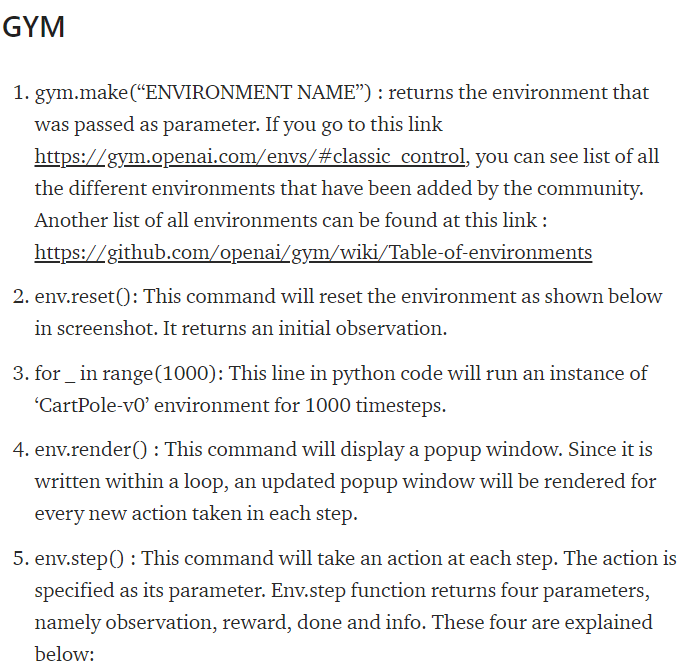

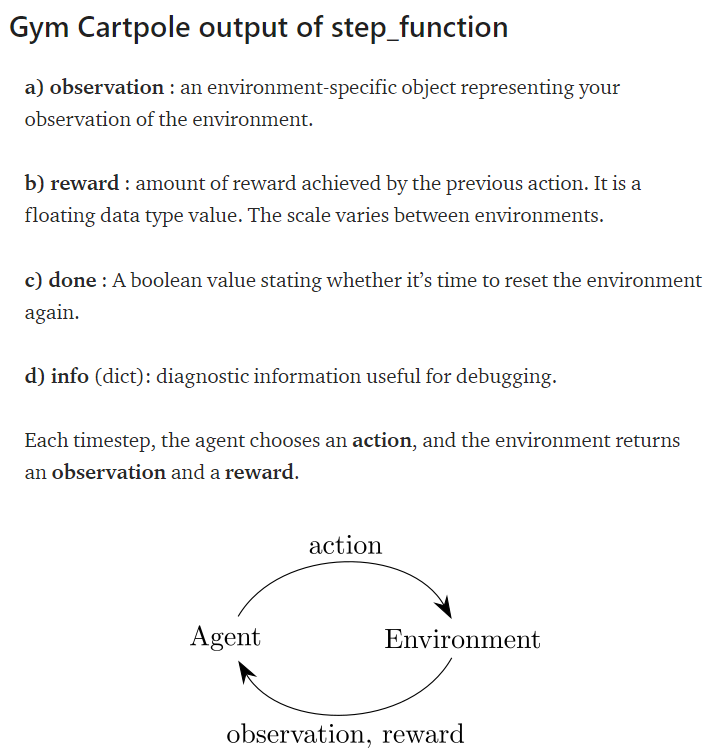

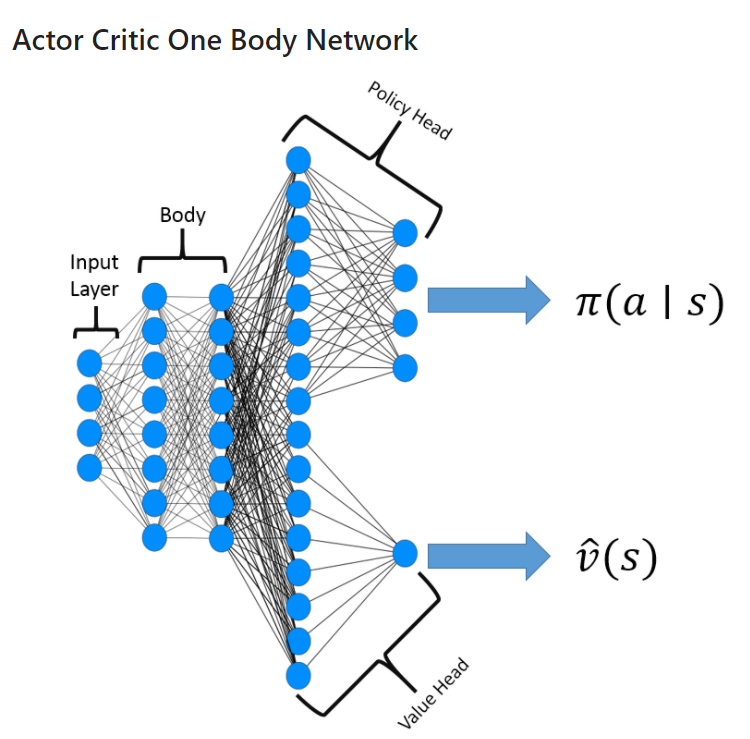

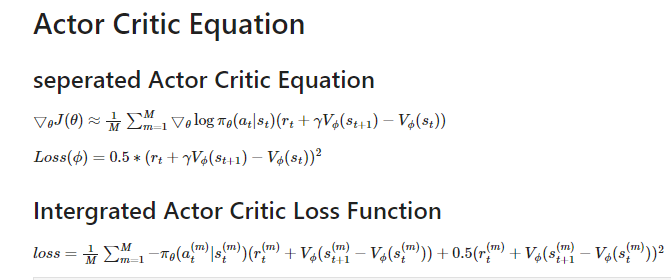

# Intergrated PPO Algorithm

$r_t(\theta)=\frac{\pi_\theta(a_t | s_t)}{\pi_{old}(a_t | s_t)}$

$A^{GAE}_\phi = \sum_{n=1}^{\infty} (\gamma * \lambda)^{n-1} \delta_n $

$\delta_t=r_t+\gamma V_\phi(s_{t+1})-V_\phi (s_t)$

$L_m^{clip}=min(r_m(\theta)A_m^{GAE},clip(r_m(\theta),1-\epsilon,1+\epsilon)A_m^{GAE})$

$Loss=\frac{1}{M} \sum_{m=1}^M -L_m^{clip} + 0.5(r_m+\gamma V_\phi(s_{m+1})-V_\phi(s_m))^2$

$Critic Loss GAE를 사용할 수도 있지만 성능이 기존 1-step보다 좋지 못해 Critic Loss는 1-time \; step을 사용하였다.$

In [40]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.fc1   = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()
            advantage_lst = []
            advantage = 0.0
            #Reverse
            #n_step value function에서 advantage를 Generalized Value Estimation 사용
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))
            #
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [41]:
reward_list=list()
env = gym.make('CartPole-v1')
model = PPO()
score = 0.0
print_interval = 5

for n_epi in range(500):
    s = env.reset()
    done = False
    while not done:
        for t in range(T_horizon):
            prob = model.pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            model.put_data((s, a, r/100.0, s_prime, prob[a].item(), done))
            s = s_prime
            score += r
            if done:
                break
            #쵀대 episode의 최대 time_step 길이는 20이다.
        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        reward_list.append(score/print_interval)
        if score/print_interval==250.0:
            break
        score = 0.0
    


env.close()



# of episode :5, avg score : 19.4
# of episode :10, avg score : 26.2
# of episode :15, avg score : 46.4
# of episode :20, avg score : 29.8
# of episode :25, avg score : 49.8
# of episode :30, avg score : 48.2
# of episode :35, avg score : 41.2
# of episode :40, avg score : 74.4
# of episode :45, avg score : 76.0
# of episode :50, avg score : 64.8
# of episode :55, avg score : 72.0
# of episode :60, avg score : 77.2
# of episode :65, avg score : 73.6
# of episode :70, avg score : 26.0
# of episode :75, avg score : 45.8
# of episode :80, avg score : 131.0
# of episode :85, avg score : 93.8
# of episode :90, avg score : 116.8
# of episode :95, avg score : 142.0
# of episode :100, avg score : 200.6
# of episode :105, avg score : 247.0
# of episode :110, avg score : 136.6
# of episode :115, avg score : 257.4
# of episode :120, avg score : 209.2
# of episode :125, avg score : 169.6
# of episode :130, avg score : 137.4
# of episode :135, avg score : 193.0
# of episode :140, avg score : 282.8


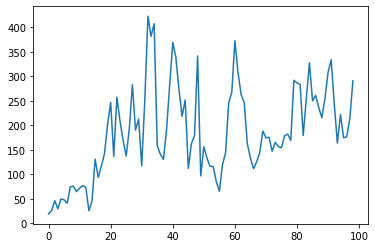

In [42]:
import matplotlib.pyplot as plt

plt.plot(reward_list)
plt.show()